In [1]:
%load_ext autotime

time: 139 µs (started: 2023-11-08 10:14:37 +01:00)


In [2]:
import warnings
warnings.filterwarnings('ignore')

time: 246 µs (started: 2023-11-08 10:14:37 +01:00)


In [3]:
import json
# from mei import Size_Distribution_Optics
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

time: 1.63 s (started: 2023-11-08 10:14:37 +01:00)


In [4]:
import glob
import dask.dataframe as dd

time: 645 ms (started: 2023-11-08 10:14:38 +01:00)


In [5]:
import sklearn
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer
from sklearn.metrics import r2_score 
import joblib

time: 751 ms (started: 2023-11-08 10:14:39 +01:00)


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Activation

from tensorflow.keras.callbacks import ModelCheckpoint, TerminateOnNaN, ReduceLROnPlateau, EarlyStopping

2023-11-08 10:14:40.079753: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 10:14:40.565336: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-08 10:14:40.565368: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-11-08 10:14:42.574854: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

time: 5.42 s (started: 2023-11-08 10:14:40 +01:00)


In [7]:
def normalize(df):
    return (df - df.mean()) / df.std()

def normalize1(df):    
    mx = df.max()
    mn = df.min()
    
    mx['SSA'] = 1.0
    mx['Asym'] = 1.0
    
    mn['SSA'] = 0.0
    mn['Asym'] = 0.0
    
    new = (df - mn) / (mx - mn)    
    return new


def load_opt(filename):
    with open(filename, "r") as fp:
        data = json.load(fp)
    return data


def create_model(
    input_size,
    output_size,
    hidden=[14, 16, 5, 10],
    dropout=[0.1, 0.3, 0.3, 0],
    activation=["relu", "tanh", "tanh", "tanh"],
    loss="mean_absolute_error",
    optimizer="adam",
    metrics=["mean_squared_error"],
):
    input_shape = (input_size,)
    print(f"Input shape: {input_shape}")

    # Create the model
    model = Sequential()
    model.add(
        Dense(
            hidden[0],
            input_shape=input_shape,
            activation=activation[0],
            name="hidden_layer_1",
            use_bias=True,
        ),
    )
    model.add(Dropout(dropout[0]))

    if len(hidden) > 1:
        for i, (ly , act, drp) in enumerate(zip(hidden[1:], activation[1:], dropout[1:])):
            model.add(
                Dense(
                    ly,
                    activation=act,
                    name="hidden_layer_%s" % (i + 2),
                    use_bias=True,
                )
            )
            model.add(Dropout(drp))
    # model.add(Dense(output_size, activation="sigmoid", name="output_layer"))
    model.add(Dense(output_size, name="output_layer"))

    # Configure the model and start training
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    print(model.summary())
    return model

time: 1.53 ms (started: 2023-11-08 10:14:45 +01:00)


In [8]:
columns = ['Extinction', 'Scattering', 'SSA', 'Asym', 'coating', 'core_dia', 'n_core', 'k_core', 'n_shell', 'k_shell', 'density', 'lambda']
df1 = pd.read_csv('/work/bb1070/b382177/mie/icon/12-05-2023/mie_x1.csv', index_col=0).sort_index().sort_index().iloc[:-1224, :]
df2 = pd.read_csv('/work/bb1070/b382177/mie/icon/12-05-2023/mie_x2.csv', index_col=0).sort_index().sort_index().iloc[:-1224, :]
df = pd.concat([df1, df2], axis=0).reset_index()
df = df[columns].dropna().astype('float')
df['x'] = np.pi * df['core_dia'] / df['lambda']
df

,Extinction,Scattering,SSA,Asym,coating,core_dia,n_core,k_core,n_shell,k_shell,density,lambda,x
0,2.371424,1.497649,0.631540,0.898342,0.0,4000.0,1.451990,0.022362,1.330928,4.128916e-08,2.6,700.0,17.951958
1,2.203139,1.330449,0.603888,0.882517,0.0,5000.0,1.453480,0.023396,1.327650,2.061950e-06,2.6,950.0,16.534698
2,2.173950,1.202943,0.553344,0.947042,0.0,9000.0,1.451020,0.018632,1.332398,9.574458e-09,2.6,600.0,47.123890
3,2.068879,1.123843,0.543213,0.952623,0.0,10000.0,1.483700,0.099080,1.389200,9.470000e-08,2.6,210.0,149.599650
4,2.150144,1.163233,0.541003,0.941646,0.0,10000.0,1.453000,0.022940,1.329120,3.110181e-07,2.6,850.0,36.959914
...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,0.184309,0.033168,0.179958,0.086705,0.4,700.0,1.394680,0.006191,1.420600,1.426000e-01,1.7,4600.0,0.478068
599996,0.181849,0.010640,0.058508,0.054755,0.4,900.0,1.364826,0.022669,1.276529,1.827067e-01,1.7,7100.0,0.398230
599997,0.265074,0.004225,0.015940,0.016758,0.4,3000.0,1.613500,0.648098,2.010000,6.500000e-01,1.7,50000.0,0.188496
599998,0.193847,0.001301,0.006709,0.009228,0.4,4000.0,1.613500,0.648098,2.020000,6.850000e-01,1.7,90000.0,0.139626


time: 4.12 s (started: 2023-11-08 10:14:45 +01:00)


In [9]:
mx = df.max()
mn = df.min()
pd.concat([pd.DataFrame(mx), pd.DataFrame(mn)], axis=1)#.to_csv('/work/bb1070/b382177/mie/icon/05-07-2023/model/mlp_min_max.csv')

,0,0
Extinction,4.427469,3.949925e-07
Scattering,4.427461,2.459024e-15
SSA,1.000367,1.902386e-11
Asym,0.980657,1.920404e-08
coating,0.400000,0.000000e+00
core_dia,20000.000000,1.000000e+01
n_core,2.768000,1.066360e+00
k_core,1.002280,5.000000e-09
n_shell,2.094000,1.172000e+00
k_shell,0.730000,1.062778e-09


time: 25 ms (started: 2023-11-08 10:14:49 +01:00)


In [10]:
qt = QuantileTransformer(n_quantiles=1000, output_distribution="normal", random_state=0)
df_shuffled = df.sample(frac=1, random_state=40).reset_index(drop=True)
df_shuffled = normalize1(df_shuffled)

out_col = ["Extinction", "Scattering", "Asym"]
in_col = ['coating', 'x', 'n_core', 'k_core', 'n_shell', 'k_shell', 'lambda']

y = df_shuffled[out_col]
y[out_col] = qt.fit_transform(y)
x = df_shuffled[in_col]

split = 0.9
train_size = int(split * len(x))
train_x = x.iloc[:train_size, :].reset_index(drop=True)
train_y = y.iloc[:train_size, :].reset_index(drop=True)
test_x = x.iloc[train_size:, :].reset_index(drop=True)
test_y = y.iloc[train_size:, :].reset_index(drop=True)
train_y

,Extinction,Scattering,Asym
0,-0.385656,-0.134130,-0.108732
1,-0.825163,-0.511151,-0.509331
2,1.483993,1.338700,0.826924
3,-0.051317,-0.452069,-0.513292
4,0.518457,0.429787,1.835915
...,...,...,...
539995,-0.990207,-0.841703,-0.810697
539996,0.220158,0.192439,0.161772
539997,-0.956842,-5.199338,-1.599475
539998,-0.213032,-0.563891,-0.612526


time: 613 ms (started: 2023-11-08 10:14:49 +01:00)


In [11]:
model = tf.keras.models.load_model('/work/bb1070/b382177/mie/icon/17-08-2023/model/model_17-08-2023.h5')

time: 207 ms (started: 2023-11-08 10:14:50 +01:00)


2023-11-08 10:14:50.332094: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-11-08 10:14:50.332127: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-08 10:14:50.332143: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (l40004.lvt.dkrz.de): /proc/driver/nvidia/version does not exist
2023-11-08 10:14:50.332624: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
pred_y = model.predict(test_x)
pred_y = pd.DataFrame(pred_y, columns=out_col)

1875/1875 [==============================] - 1s 535us/step
time: 1.67 s (started: 2023-11-08 10:14:50 +01:00)


In [13]:
test_y[out_col] = qt.inverse_transform(test_y)
pred_y[out_col] = qt.inverse_transform(pred_y)

time: 41.8 ms (started: 2023-11-08 10:14:52 +01:00)


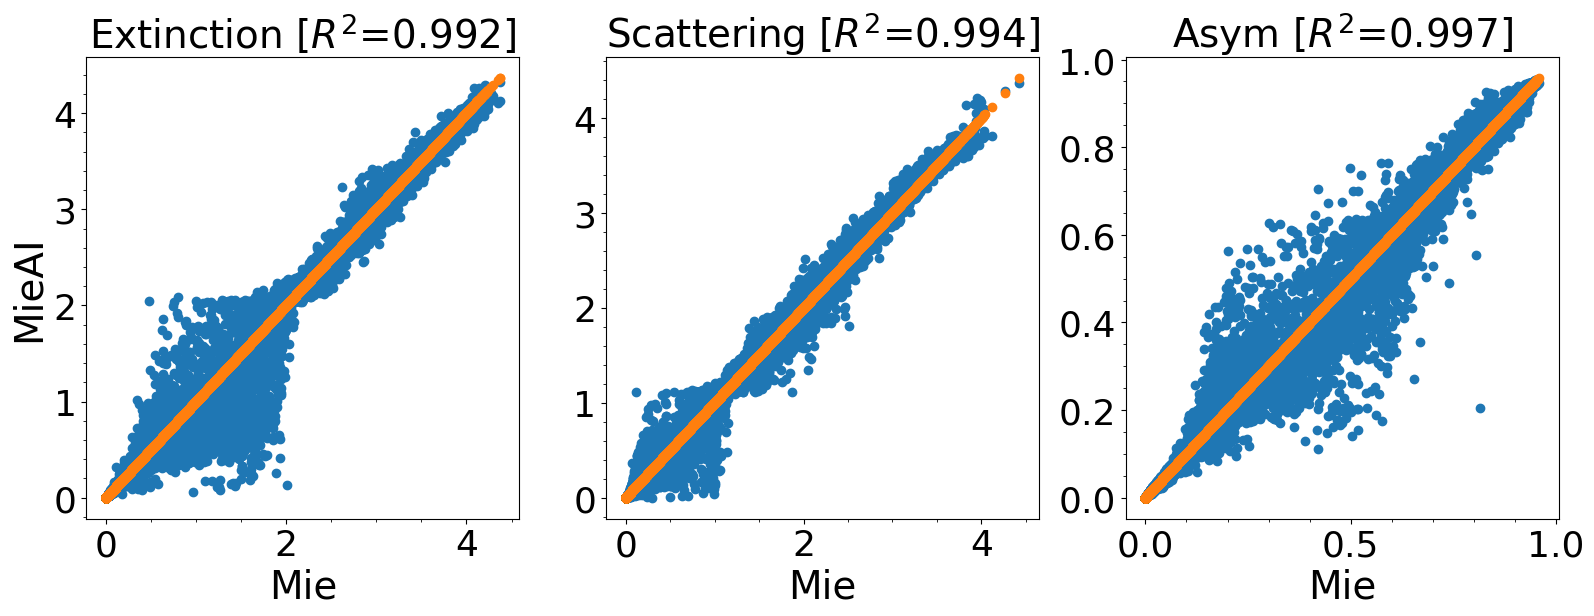

time: 2.5 s (started: 2023-11-08 10:26:00 +01:00)


In [35]:
fig, axes = plt.subplots(1, 3, figsize=(19, 6))
for col, ax in zip(y.columns, axes):
    ntest = test_y[col]
    npred = pred_y[col]
        
    corr = np.corrcoef(ntest, npred)[0,1]
    r2 = r2_score(ntest, npred)
    
    x1 = test_y[col]
    y1 = pred_y[col]    

    x1 = (mx[col] - mn[col]) * x1 + mn[col]
    y1 = (mx[col] - mn[col]) * y1 + mn[col]
        
    ax.scatter(x1, y1)
    ax.scatter(x1, x1)
    ax.set_title('%s [$R^2$=%0.3f]'%(col, r2), fontsize=28)
    ax.set_xlabel('Mie', fontsize=28)
    ax.minorticks_on()
    ax.tick_params(labelsize=26)
axes[0].set_ylabel('MieAI', fontsize=28)
plt.savefig("/work/bb1070/b382177/mie/icon/17-08-2023/figs/mlp_accuracy_stats.png", bbox_inches="tight")
plt.show()   

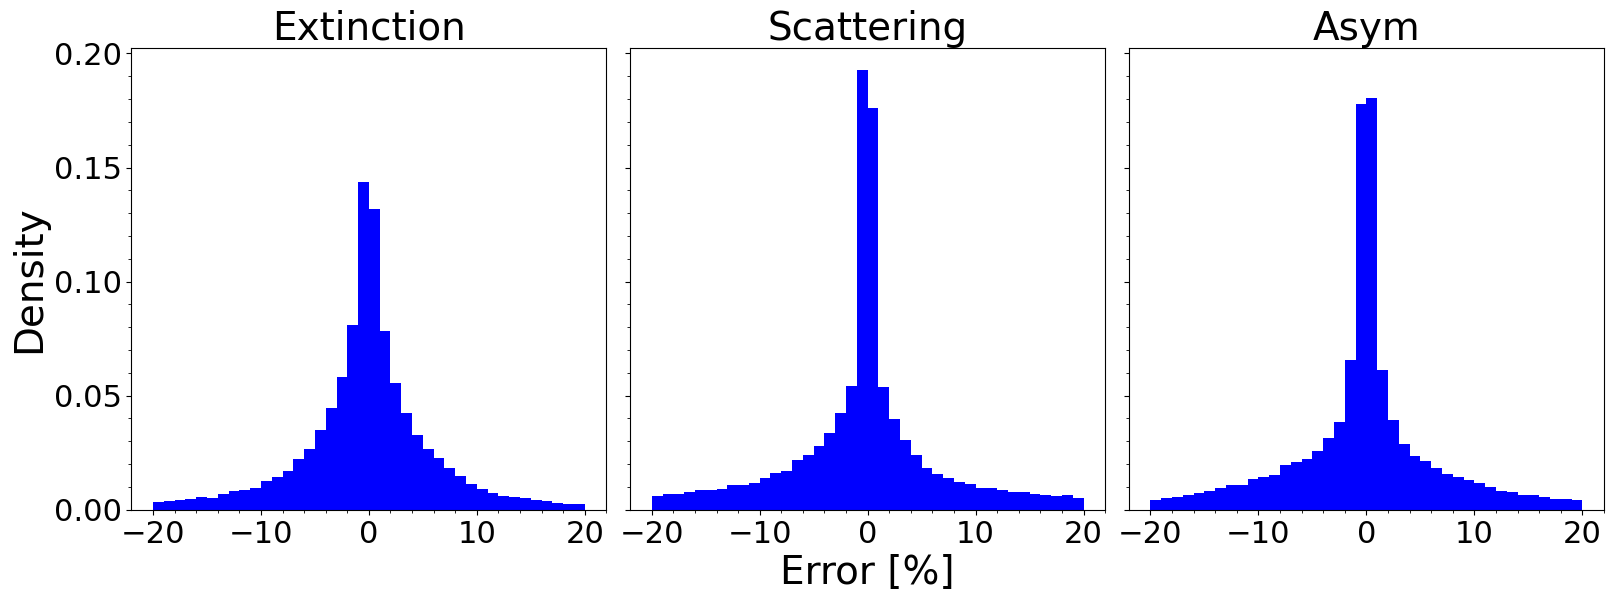

time: 861 ms (started: 2023-11-08 10:28:07 +01:00)


In [40]:
fig, axes = plt.subplots(1, 3, figsize=(19, 6), sharey=True)
axes = axes.flatten()
for i, (col, ax) in enumerate(zip(y.columns, axes)):
    ntest = test_y[col]
    npred = pred_y[col]  
    
    x1 = test_y[col]
    y1 = pred_y[col]  
    
    x1 = (mx[col] - mn[col]) * x1 + mn[col]
    y1 = (mx[col] - mn[col]) * y1 + mn[col]
    
    corr = np.corrcoef(x1, y1)[0,1]    
    error = 100 * (y1 - x1) / x1   
    
    ax.hist(error, bins=np.arange(-20, 21, 1), density=True, color='blue')
    # ax.hist(error, bins=100, density=True)
    
    # ax.set_title('%s [R=%0.3f]'%(col, corr), fontsize=20)
    ax.set_title('%s'%(col), fontsize=28, y=0.999)
    ax.set_xlabel('Error [%]', fontsize=28)
    ax.set_ylabel('Density', fontsize=28)
    if i!=0:
        ax.set_ylabel('', fontsize=20)
        
    if i!=1:
        ax.set_xlabel('', fontsize=20)
        
    ax.minorticks_on()
    ax.set_yticks(np.arange(0, 0.25, 0.05))
    ax.tick_params(labelsize=22)
    
plt.subplots_adjust(hspace=0.01, wspace=0.05)
plt.savefig('/work/bb1070/b382177/mie/icon/17-08-2023/figs/mlp_error_ana.png', bbox_inches='tight')
plt.show()